In [1]:
import stVGP
import scanpy as sc
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

d:\anaconda\envs\xw_cuda117\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# DLPFC 
# Multiple slices
# Input spatial transcriptomics dataset
# annotated data
anno_df = pd.read_csv('C:/Users/wzd/Downloads/stVGP_F/data/barcode_level_layer_map.tsv', sep='\t', header=None)
slice_idx = [151673, 151674, 151675, 151676]

adata_st1 = sc.read_visium(path="C:/Users/wzd/Downloads/stVGP_F/data/%d" % slice_idx[0],
                        count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[0])
print(adata_st1)
anno_df1 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[0])]
anno_df1.columns = ["barcode", "slice_id", "layer"]
anno_df1.index = anno_df1['barcode']
adata_st1.obs = adata_st1.obs.join(anno_df1, how="left")
adata_st1 = adata_st1[adata_st1.obs['layer'].notna()]

adata_st2 = sc.read_visium(path="C:/Users/wzd/Downloads/stVGP_F/data/%d" % slice_idx[1],
                        count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[1])
print(adata_st2)
anno_df2 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[1])]
anno_df2.columns = ["barcode", "slice_id", "layer"]
anno_df2.index = anno_df2['barcode']
adata_st2.obs = adata_st2.obs.join(anno_df2, how="left")
adata_st2 = adata_st2[adata_st2.obs['layer'].notna()]

adata_st3 = sc.read_visium(path="C:/Users/wzd/Downloads/stVGP_F/data/%d" % slice_idx[2],
                        count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[2])
print(adata_st3)
anno_df3 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[2])]
anno_df3.columns = ["barcode", "slice_id", "layer"]
anno_df3.index = anno_df3['barcode']
adata_st3.obs = adata_st3.obs.join(anno_df3, how="left")
adata_st3 = adata_st3[adata_st3.obs['layer'].notna()]

adata_st4 = sc.read_visium(path="C:/Users/wzd/Downloads/stVGP_F/data/%d" % slice_idx[3],
                        count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[3])
print(adata_st4)
anno_df4 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[3])]
anno_df4.columns = ["barcode", "slice_id", "layer"]
anno_df4.index = anno_df4['barcode']
adata_st4.obs = adata_st4.obs.join(anno_df4, how="left")
adata_st4 = adata_st4[adata_st4.obs['layer'].notna()]

adata_st_list_raw = [adata_st1,adata_st2,adata_st3,adata_st4]
adata_st_list = stVGP.st_preprocess(adata_st_list_raw,
                                       n_hvg_group=5000,
                                       min_genes=1,
                                       min_cells=100,
                                       flavor = "seurat")

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3592 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
Finding highly variable genes...


In [3]:
# Analysing spatial regionality genes
# Analysed with the help of R
# If a multi-slice spatial feature gene analysis is not performed, the first analysis is used by default
ref_label = 0
adata_st_list = stVGP.select_gene(
                                adata_st_list,
                                ref_adata_num = ref_label,
                                spot_make = 3,                  # 3*3 equal divisions
                                key_words = 'spatial',
                                save_data = False,
                                savepath = 'C:/Users/wzd/Downloads/stVGP_F/data/gene_select/')
# Next, the genes will be analyzed using seurat and the spatial morans analysis will be performed on the filtered genes. 
# The details of the analysis are in Spatial genetic analysis DLPFC.R

In [4]:
# space-specific gene
gene_morans_result = np.genfromtxt('C:/Users/wzd/Downloads/stVGP_F/data/gene_select/gene_morans_9.txt',
                                   dtype=np.str0,
                                   skip_header=1,
                                   delimiter ='\t')

sorted_indices = np.argsort(gene_morans_result[:,-1])[::-1]
top_morans_indices = sorted_indices[:10]
select_gene_final = gene_morans_result[top_morans_indices,0]

In [5]:
# Gene expression point alignment
adata_st_list = stVGP.gene_rigid_alignment(
        gene_input = select_gene_final,                                  
        stadata_input = adata_st_list,                               
        ini_spatial = 'spatial',                       
        add_spatial = 'align_spatial',                
        align_model = "single_template_alignment",    
        gene_input_list = None,                     
        ref_label = ref_label,                                
        align_method = 'optimize',                    
        icp_iterations = 20,                          
        maxiter = 300)

# Gene expression parallel alignment
adata_st_list = stVGP.gene_rigid_mapping_alignment(
        gene_input = select_gene_final,                                  
        stadata_input = adata_st_list,                               
        ini_spatial  = 'spatial',                       
        add_spatial = 'align_spatial',              
        align_model = "single_template_alignment",    
        gene_input_list = None,                      
        angle_input_list = None,                     
        ref_label = ref_label,                               
        if_all_angle = False,                       
        ini_angle = 0.0,                            
        angle_params = [-60,-40,-20,0,20,40,60])

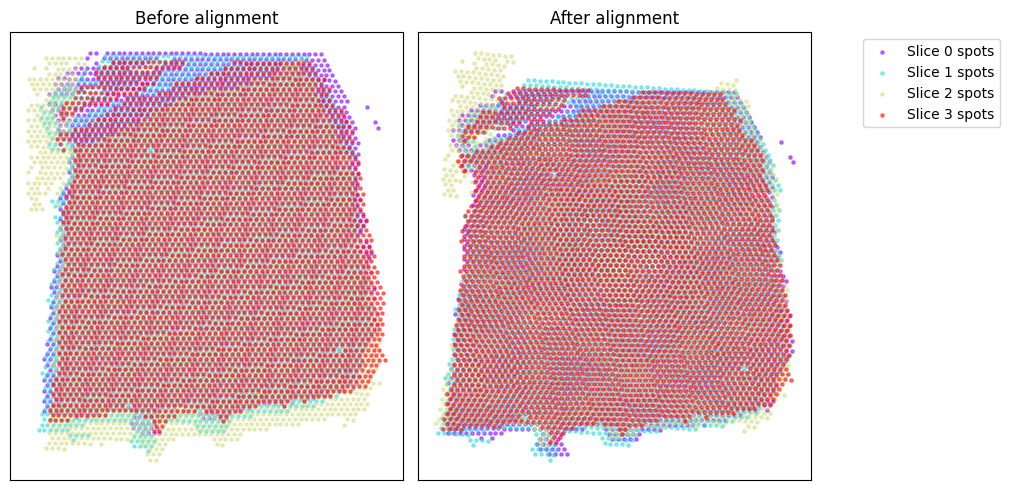

In [6]:
# alignment result
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming analysis_adata is already defined
cmap = cm.get_cmap('rainbow', len(adata_st_list))
colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(adata_st_list))]

# Create a figure with 1 row and 2 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot spots before alignment
axes[0].set_title("Before alignment")
for i in range(len(adata_st_list)):
    axes[0].scatter(adata_st_list[i].obsm['spatial'][:, 0], 
        adata_st_list[i].obsm['spatial'][:, 1], 
        c=colors_list[i],
        label="Slice %d spots" % i, s=5., alpha=0.5)
axes[0].invert_yaxis()
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot spots after alignment (example, assuming after alignment data is available)
axes[1].set_title("After alignment")
for i in range(len(adata_st_list)):
    axes[1].scatter(adata_st_list[i].obsm['align_spatial'][:, 0], 
        adata_st_list[i].obsm['align_spatial'][:, 1], 
        c=colors_list[i],
        label="Slice %d spots" % i, s=5.5, alpha=0.5)
axes[1].invert_yaxis()
axes[1].set_xticks([])
axes[1].set_yticks([])

# Adjust layout to prevent overlap
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.tight_layout()

plt.show()

In [12]:
# Save the result after alignment
# for adata in adata_st_list:
#     silce_id = str(int(adata.obs['slice_id'][0]))
#     adata.write("C:/Users/wzd/Downloads/stVGP_F/data/{}_slice.h5ad".format(silce_id))

In [7]:
# Domain and batch effect
import scanpy as sc
import torch
import anndata as ad
# Re-enter data
data_path = 'C:/Users/wzd/Downloads/stVGP_F/data/'
slice_idx = [151673, 151674, 151675, 151676]
adata_DLPFC_list = []
for slice_name in slice_idx:
    file_path = data_path + str(slice_name) + '_slice.h5ad'
    adata = sc.read(file_path)
    adata = adata[~adata.obs['layer'].isna()]
    adata_DLPFC_list.append(adata)

In [8]:
# Preprocessed data
# If the data was not processed during the alignment process, perform preliminary processing of the data
slice_matrix,adj_matrix = stVGP.adata_preprocess_adjnet(
        input_adata = adata_DLPFC_list,                                 
        align_model = 'single_template_alignment',    
        ref_label = 0,                               
        spatial_label = 'align_spatial',              
        add_net_keywords_self = 'adj_spatial_net',    
        n_neighbors = 10,                             
        no_cross = False
        )


In [10]:
recon_x, embedding, model_params,logvar = stVGP.train_stVGP(
        ST_need_reconstruction_matrix = slice_matrix,
        all_spatial_net = adj_matrix,
        lr = 0.001,
        weight_decay = 0.0001,
        training_epoch = 1200,
        num_heads = 1,
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        save_model = False,
        save_model_path = 'path',
        hidden_embedding = [512,24],
        random_seed = 112,
        optimize_method = 'adam',
        whether_gradient_clipping = False,
        gradient_clipping = 5.0,
        all_gat = True)

Model training


100%|██████████| 1200/1200 [01:42<00:00, 11.71it/s]


In [11]:
# Save embedded layer data
# np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Domain/embedding.txt',embedding,fmt='%s')

In [14]:
# Domain result
from mclustpy import mclustpy
from sklearn.metrics import adjusted_rand_score

embedding = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Domain/embedding.txt')

data_dim = np.cumsum(np.array([adata_DLPFC_list[0].X.shape[0],
                               adata_DLPFC_list[1].X.shape[0],
                               adata_DLPFC_list[2].X.shape[0],
                               adata_DLPFC_list[3].X.shape[0]]))
data_dim = np.insert(data_dim,0,0)

true_labels = np.vstack((np.array(adata_DLPFC_list[0].obs['layer']).reshape(-1,1),
                        np.array(adata_DLPFC_list[1].obs['layer']).reshape(-1,1),
                        np.array(adata_DLPFC_list[2].obs['layer']).reshape(-1,1),
                        np.array(adata_DLPFC_list[3].obs['layer']).reshape(-1,1))).ravel()
cluster_num = len(np.unique(true_labels))

res = mclustpy(embedding, G=cluster_num, modelNames='EEE', random_seed=1)
pre_labels = np.array(res['classification'])
ari = adjusted_rand_score(true_labels, pre_labels)
print(ari)

fitting ...
  |======================================================================| 100%
0.6386810818801821


In [15]:
# Storing Model Results
AP_z_slice_0 = [10.] * adata_DLPFC_list[0].X.shape[0]
AP_z_slice_1 = [20.] * adata_DLPFC_list[1].X.shape[0]
AP_z_slice_2 = [320.] * adata_DLPFC_list[2].X.shape[0]
AP_z_slice_3 = [330.] * adata_DLPFC_list[3].X.shape[0]

AP_z = np.vstack((np.array(AP_z_slice_0).reshape(-1,1),
                 np.array(AP_z_slice_1).reshape(-1,1),
                 np.array(AP_z_slice_2).reshape(-1,1),
                 np.array(AP_z_slice_3).reshape(-1,1)))

spatial_spots = np.vstack((np.array(adata_DLPFC_list[0].obsm['align_spatial']),
                          np.array(adata_DLPFC_list[1].obsm['align_spatial']),
                          np.array(adata_DLPFC_list[2].obsm['align_spatial']),
                          np.array(adata_DLPFC_list[3].obsm['align_spatial'])))

spatial_spots = np.hstack((spatial_spots,AP_z))

# np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Domain/alignment_spatial.txt',spatial_spots,fmt='%s')
# np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Domain/cluster.txt',pre_labels,fmt='%s')
# torch.save(model_params, "C:/Users/wzd/Downloads/stVGP_F/data/Domain/model.pth")

In [16]:
# Prediction and 3Dreconstruction
# Reload data
spatial = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Domain/alignment_spatial.txt')
embedding = np.loadtxt("C:/Users/wzd/Downloads/stVGP_F/data/Domain/embedding.txt")
domain = np.loadtxt("C:/Users/wzd/Downloads/stVGP_F/data/Domain/cluster.txt")

In [17]:
AP_pred = [30]
spatial_pred_xy = spatial[data_dim[1]:data_dim[2]][:,:2]
pred_spatial_A = spatial_pred_xy + np.random.uniform(low=-5, high=5, size=spatial_pred_xy.shape)

z_A = np.array([AP_pred[0]] * pred_spatial_A.shape[0]).reshape(-1,1)
pred_spatial_A = np.hstack((pred_spatial_A,z_A))

Truth_30 = true_labels[data_dim[1]:data_dim[2]]

# np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/30_Truth.txt',Truth_30,fmt='%s')
# np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/30_spatial.txt',pred_spatial_A,fmt='%s')

In [18]:
embedding_pred_A = stVGP.get_3D_prediction(
                    train_coordinates = spatial,
                    embedding = embedding,
                    spatial_pred = pred_spatial_A,
                    noise = False,
                    noise_value = 0.00001,
                    constant_value = 1.0,
                    Rbf_value = 512)

# np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/30_embedding.txt',embedding_pred_A,fmt='%s')

In [19]:
# Virtual slicing domain
embedding_sum = np.vstack((embedding,embedding_pred_A))
res_sum = mclustpy(embedding_sum, G=cluster_num, modelNames='EEE', random_seed=1)
pred_slices_labels = np.array(res['classification'])[-embedding_pred_A.shape[0]:]

# np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/30_cluster.txt',pred_slices_labels,fmt='%s')

fitting ...
  |======================================================================| 100%


In [20]:
# Consolidated projected results
Prediction_30_spatial = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/30_spatial.txt')
Prediction_30_embedding = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/30_embedding.txt')
Prediction_30_cluster = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/30_cluster.txt').reshape(-1,1)
Prediction_30_truth = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/30_Truth.txt',dtype=str).reshape(-1,1)
ari_pred = adjusted_rand_score(Prediction_30_cluster.ravel(),Prediction_30_truth.ravel())
ari_pred = np.array([ari_pred] * len(Prediction_30_truth))
AP_z_30_result = np.hstack((Prediction_30_spatial,Prediction_30_embedding,Prediction_30_cluster,Prediction_30_truth))

# np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/AP_z_30_result.txt',pred_slices_labels,fmt='%s')

In [21]:
data_path = 'C:/Users/wzd/Downloads/stVGP_F/data/'
slice_idx = [151673, 151674, 151675, 151676]
adata_DLPFC_list = []
for slice_name in slice_idx:
    file_path = data_path + str(slice_name) + '_slice.h5ad'
    adata = sc.read(file_path)
    adata = adata[~adata.obs['layer'].isna()]
    adata_DLPFC_list.append(adata)

data_dim = np.cumsum(np.array([adata_DLPFC_list[0].X.shape[0],
                               adata_DLPFC_list[1].X.shape[0],
                               adata_DLPFC_list[2].X.shape[0],
                               adata_DLPFC_list[3].X.shape[0]]))
data_dim = np.insert(data_dim,0,0)

In [22]:
from sklearn.metrics import adjusted_rand_score
pred_30 = pd.read_csv("C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/AP_z_30_result.txt",sep=' ', header=None)
domain = np.loadtxt("C:/Users/wzd/Downloads/stVGP_F/data/Domain/cluster.txt")
embedding_list = []
for i in range(24):
    embedding_list.append('embedding_{}'.format(i))
embedding_list = embedding_list + ['cluster','layer','ARI']
embedding_list = ['x','y','z'] + embedding_list
pred_30.columns = embedding_list

adata_DLPFC_list[1].obsm['pred_cluster'] = np.array(pred_30['cluster']).reshape(-1,1)
adata_DLPFC_list[1].obsm['pred_spatial'] = np.array(pred_30[['x','y']])
adata_DLPFC_list[1].obsm['our'] = np.array(domain[data_dim[1]:data_dim[2]])
adata_DLPFC_list[2].obsm['our'] = np.array(domain[data_dim[2]:data_dim[3]])

def get_unique_max_indices(matrix):
    rows, cols = matrix.shape
    used_cols = set()
    result = np.full(rows, -1)  

    sorted_indices = np.argsort(-matrix, axis=None) 
    for index in sorted_indices:
        row, col = divmod(index, cols)
        if result[row] == -1 and col not in used_cols:  
            result[row] = col
            used_cols.add(col)
    
    return result

def adust_cluster(true_label_df,pred_label_df):

    true_label_df = true_label_df.copy()
    pred_label_df = pred_label_df.copy()
    
    true_label = true_label_df.ravel()
    pred_label = pred_label_df.ravel()

    true_label_unique = np.unique(true_label)
    pred_label_unique = np.unique(pred_label)

    score_ari = np.zeros((len(true_label_unique),len(pred_label_unique)),dtype=np.float32)

    for key_true_index in range(len(true_label_unique)):
        new_vector_true = np.where(true_label_df == true_label_unique[key_true_index], true_label_df, str(0))
        new_vector_true = np.array(new_vector_true,dtype=str)
        new_vector_true = new_vector_true.ravel()
        for key_predin_index in range(len(pred_label_unique)):
            new_vector_pred = np.where(pred_label_df == pred_label_unique[key_predin_index], pred_label_df, str(0))
            new_vector_pred = np.array(new_vector_pred,dtype=str)
            new_vector_pred = new_vector_pred.ravel()
            ari = adjusted_rand_score(new_vector_true,new_vector_pred)
            score_ari[key_true_index][key_predin_index] = ari

    score_col = get_unique_max_indices(score_ari)

    mapping_dict = {}

    for index in range(len(score_col)):
        mapping_dict[true_label_unique[index]] = pred_label_unique[score_col[index]]

    return mapping_dict

from scipy.spatial.distance import cdist
distanc_matrix = cdist(adata_DLPFC_list[1].obsm['pred_spatial'],adata_DLPFC_list[1].obsm['pred_spatial'])
min_indices = np.argsort(distanc_matrix, axis=1)[:, 1:15]
cluster_new = []
for index,value in enumerate(min_indices):
    unique, counts = np.unique(adata_DLPFC_list[1].obsm['pred_cluster'][min_indices[index]], return_counts=True)
    most_frequent_element = unique[np.argmax(counts)]
    cluster_new.append(most_frequent_element)
cluster_new = np.array(cluster_new).reshape(-1,1)
adata_DLPFC_list[1].obsm['pred_clear'] = cluster_new

distanc_matrix = cdist(adata_DLPFC_list[1].obsm['pred_spatial'],adata_DLPFC_list[1].obsm['pred_spatial'])
min_indices = np.argsort(distanc_matrix, axis=1)[:, 1:14]
cluster_new = []
for index,value in enumerate(min_indices):
    unique, counts = np.unique(adata_DLPFC_list[1].obsm['pred_clear'][min_indices[index]], return_counts=True)
    most_frequent_element = unique[np.argmax(counts)]
    cluster_new.append(most_frequent_element)
cluster_new = np.array(cluster_new).reshape(-1,1)
adata_DLPFC_list[1].obsm['pred_clear'] = cluster_new

mapping_dict_pred = adust_cluster(adata_DLPFC_list[1].obsm['pred_clear'],adata_DLPFC_list[1].obsm['our'])
def replace_key_with_value_pred(key):
        return mapping_dict_pred[key]
vectorized_replace_pred = np.vectorize(replace_key_with_value_pred)
result_array_pred = vectorized_replace_pred(np.array(adata_DLPFC_list[1].obsm['pred_clear']))
adata_DLPFC_list[1].obsm['pred_adjust'] = result_array_pred.reshape(-1,1)

adata_DLPFC_list[1].obs['our'] = adata_DLPFC_list[1].obsm['our'].ravel()
adata_DLPFC_list[2].obs['our'] = adata_DLPFC_list[2].obsm['our'].ravel()
adata_DLPFC_list[1].obs['pred'] = adata_DLPFC_list[1].obsm['pred_adjust'].ravel()

Text(0, 0.5, '')

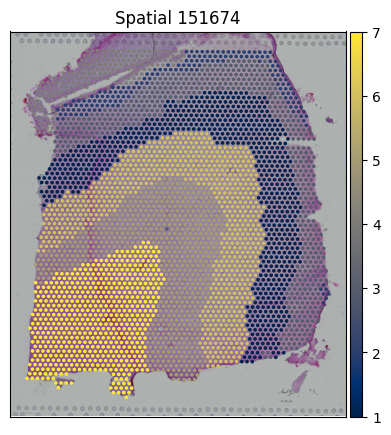

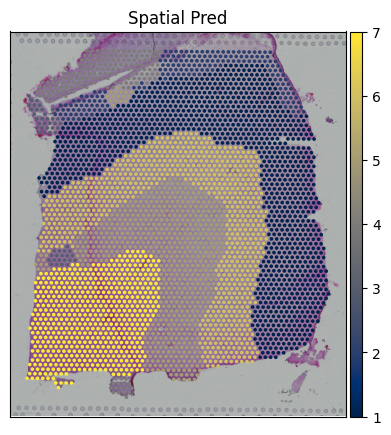

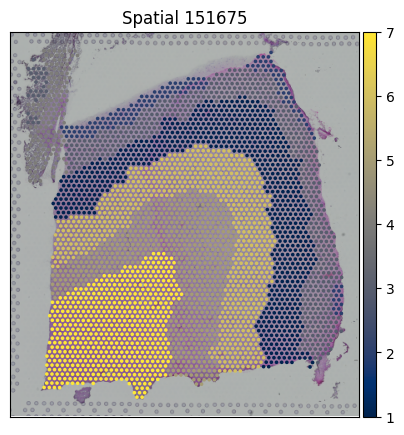

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
# cluster
sc.pl.spatial(adata_DLPFC_list[1], 
              img_key="lowres", 
              color="our", 
              color_map="cividis", 
              size=1., 
              ax=ax, 
              show=False)

# Customize the plot
ax.set_title('Spatial 151674')
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(figsize=(5, 5))
# cluster
sc.pl.spatial(adata_DLPFC_list[1], 
              img_key="lowres", 
              color="pred", 
              color_map="cividis", 
              size=1., 
              ax=ax, 
              show=False)

# Customize the plot
ax.set_title('Spatial Pred')
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(figsize=(5, 5))
# cluster
sc.pl.spatial(adata_DLPFC_list[2], 
              img_key="lowres", 
              color="our", 
              color_map="cividis", 
              size=1., 
              ax=ax, 
              show=False)

# Customize the plot
ax.set_title('Spatial 151675')
ax.set_xlabel('')
ax.set_ylabel('')

In [25]:
# Gene prediction
# Masked slices prediction

slice_idx = [151673, 151674, 151675, 151676]

spatial = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Domain/alignment_spatial.txt')
embedding = np.loadtxt("C:/Users/wzd/Downloads/stVGP_F/data/Domain/embedding.txt")

for slice_index,slice_name in enumerate(slice_idx):

    Train_spatial_up = spatial[:data_dim[slice_index]]
    Train_spatial_down = spatial[data_dim[slice_index+1]:]

    Embedding_up = embedding[:data_dim[slice_index]]
    Embedding_down = embedding[data_dim[slice_index+1]:]

    Pred_spatial = spatial[data_dim[slice_index]:data_dim[slice_index+1]]
    Pred_embedding_true = embedding[data_dim[slice_index]:data_dim[slice_index+1]]

    Train_spatial = np.vstack((Train_spatial_up,Train_spatial_down))
    Train_embedding = np.vstack((Embedding_up,Embedding_down))

    pred_embedding = stVGP.get_3D_prediction(
                train_coordinates = Train_spatial,
                embedding = Train_embedding,
                spatial_pred = Pred_spatial,
                noise = False,
                noise_value = 0.00001,
                constant_value = 1.0,
                Rbf_value = 1024)
    
    # np.savetxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/{}_prediction.txt'.format(slice_idx[slice_index]),pred_embedding,fmt='%s')

In [26]:
data_path = 'C:/Users/wzd/Downloads/stVGP_F/data/'
slice_idx = [151673, 151674, 151675, 151676]
adata_DLPFC_list = []
for slice_name in slice_idx:
    file_path = data_path + str(slice_name) + '_slice.h5ad'
    adata = sc.read(file_path)
    adata = adata[~adata.obs['layer'].isna()]
    adata_DLPFC_list.append(adata)

slice_matrix,adj_matrix = stVGP.adata_preprocess_adjnet(
        input_adata = adata_DLPFC_list,                                 
        align_model = 'single_template_alignment',    
        ref_label = 0,                               
        spatial_label = 'align_spatial',              
        add_net_keywords_self = 'adj_spatial_net',    
        n_neighbors = 10,                             
        no_cross = False
        )

In [27]:
prediction_embedding_151673 = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/151673_prediction.txt')
prediction_embedding_151674 = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/151674_prediction.txt')
prediction_embedding_151675 = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/151675_prediction.txt')
prediction_embedding_151676 = np.loadtxt('C:/Users/wzd/Downloads/stVGP_F/data/Prediction and 3D/151676_prediction.txt')
model_checkpoint = torch.load("C:/Users/wzd/Downloads/stVGP_F/data/Domain/model.pth")

prediction_embedding = np.vstack((prediction_embedding_151673,prediction_embedding_151674,prediction_embedding_151675,prediction_embedding_151676))
prediction_embedding = torch.tensor(prediction_embedding,dtype=torch.float32)

In [28]:
slice_matrix = torch.tensor(slice_matrix,dtype=torch.float32)
edge_list = []
edge_list.append(adj_matrix.row.tolist())
edge_list.append(adj_matrix.col.tolist())
adj_tensor = torch.LongTensor(edge_list)

In [29]:
Prediction_gene_expression = stVGP.gene_prediction(
    slice_matrix = slice_matrix,
    prediction_embedding = prediction_embedding,           
    adj_matrix = adj_tensor,                        
    checkpoint = model_checkpoint,                         
    model_layer = [slice_matrix.shape[1],512,24,1],                        
    all_gat = True,                            
    logvar = None,                             
    device = torch.device('cuda:0')                           
)

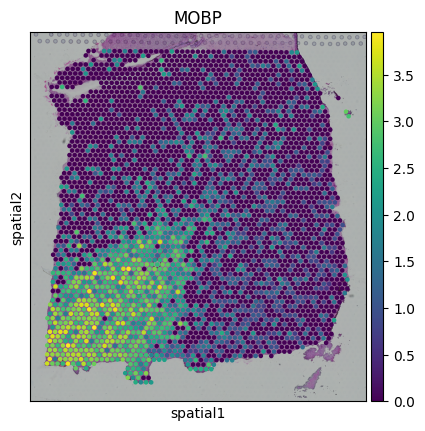

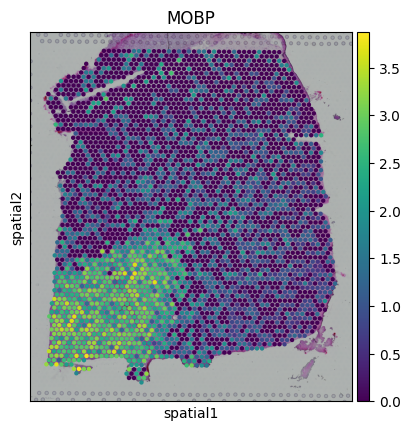

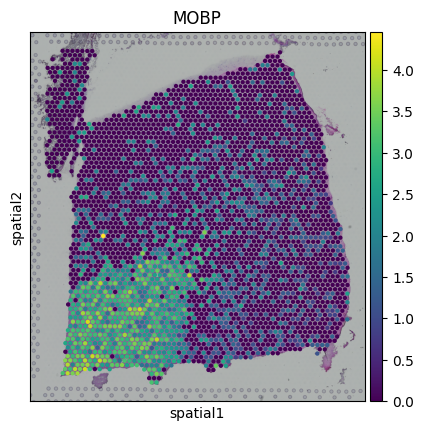

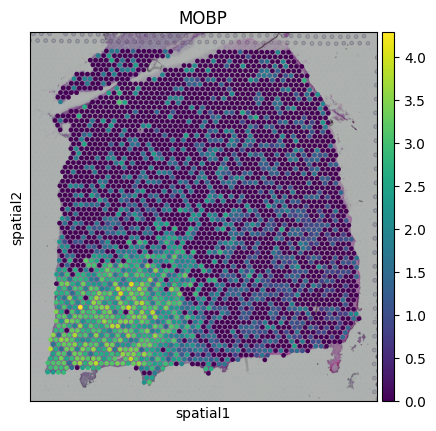

In [30]:
sc.pl.spatial(
    adata_DLPFC_list[0],
    color='MOBP',  
    spot_size=120,  
    cmap='viridis'  
)
sc.pl.spatial(
    adata_DLPFC_list[1],
    color='MOBP',  
    spot_size=120,  
    cmap='viridis'  
)
sc.pl.spatial(
    adata_DLPFC_list[2],
    color='MOBP',  
    spot_size=120,  
    cmap='viridis'  
)
sc.pl.spatial(
    adata_DLPFC_list[3],
    color='MOBP',  
    spot_size=120,  
    cmap='viridis'
)

In [31]:
data_dim = np.cumsum(np.array([adata_DLPFC_list[0].X.shape[0],
                               adata_DLPFC_list[1].X.shape[0],
                               adata_DLPFC_list[2].X.shape[0],
                               adata_DLPFC_list[3].X.shape[0]]))
data_dim = np.insert(data_dim,0,0)

for index in range(len(adata_DLPFC_list)):
    adata_DLPFC_list[index].X = Prediction_gene_expression[data_dim[index]:data_dim[index+1]]

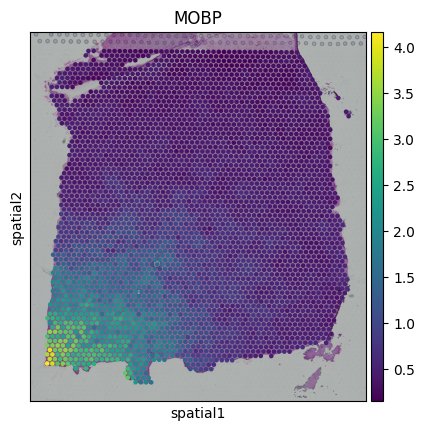

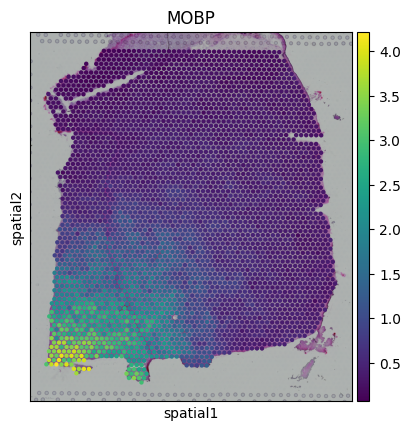

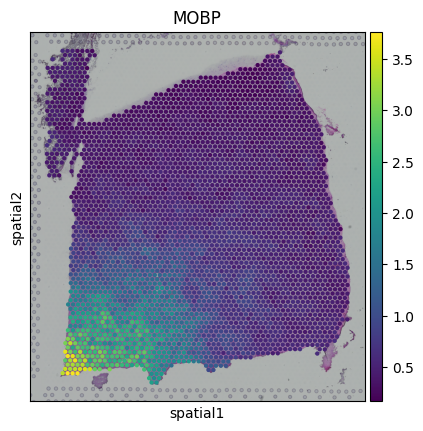

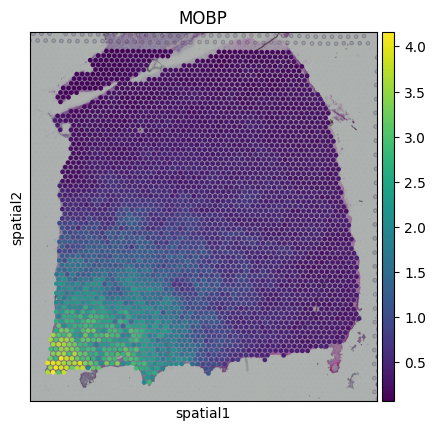

In [32]:
sc.pl.spatial(
    adata_DLPFC_list[0],
    color='MOBP',  
    spot_size=120,  
    cmap='viridis'  
)
sc.pl.spatial(
    adata_DLPFC_list[1],
    color='MOBP',  
    spot_size=120,  
    cmap='viridis'  
)
sc.pl.spatial(
    adata_DLPFC_list[2],
    color='MOBP',  
    spot_size=120,  
    cmap='viridis'  
)
sc.pl.spatial(
    adata_DLPFC_list[3],
    color='MOBP',  
    spot_size=120,  
    cmap='viridis'
)